#### **Section 1** : Business Understanding

Dataset analyzed in this notebook pertains to a fictitious digital music service provider named Sparkify. Its customers can either pay for the services and listen to songs without being interrupted by ads, or get the free version which includes ads. Aim of this project consists in understanding customer behavior through different charts and predict customer churn. Code in subsequent sections will answer following main questions:

<b> 1. </b>	What is the overall trend of daily songs played for churned and un-churned customers?

<b> 2. </b>	Who are the most played artists in the top 10 locations?

<b> 3. </b>	How does average number of songs differ between churned and un-churned customers across hours?

<b> 4. </b> How long after the registration did churned customers canceled their subscription?

<b> 5.</b> Is there any similarity in song preference between churned and un-churned customers?

<b> 6. </b>	Is there any correlation between Apple device users and churned/un-churned customers?

<b> 7. </b>	Which is the best classification model that can predict customer churn?

<b> 8. </b>	What features important in the best classification model?


In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql import functions as F
from pyspark.sql import Window
import warnings
warnings.simplefilter(action='ignore')
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 800)
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier ,  DecisionTreeClassifier , LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify Workspace") \
        .getOrCreate()


#### **Section 2** : Data Understanding

In [3]:
#Read the dataset
df_data = spark.read.json("mini_sparkify_event_data.json")
#Print dataset schema
df_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
#Get number of rows and columns
print((df_data.count(), len(df_data.columns)))

(286500, 18)


In [5]:
#Create a view to run queries
df_data.createOrReplaceTempView("df_data_table")
#Convert into a pandas dataframe for better visibilty to see how top 2 rows look like
spark.sql("SELECT * FROM df_data_table where userId = 30 LIMIT 5").toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
2,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
3,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
4,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


In [6]:
#Check for the Nulls and Nans
df_nulls = df_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_data.columns]).toPandas().T
df_nulls.rename(columns = {0:'Null Counts'} , inplace = True)
df_nulls[df_nulls['Null Counts'] > 0].sort_values(by='Null Counts')

,Null Counts
firstName,8346
gender,8346
lastName,8346
location,8346
registration,8346
userAgent,8346
artist,58392
length,58392
song,58392


Except the last 3 columns all the rest have same number of missing values - 8346.

- Explore how the dataset looks like for the rows with missing values

In [7]:
#Select top 2 rows from the dataset where firstName and gender are null
spark.sql('''SELECT  *
            FROM df_data_table  
            where userAgent is not null
            Limit 2''').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9


In [8]:
#Find the type of authentication and method for records pertaining to the subset of null records - 8346

spark.sql("SELECT  auth , method , count(*) as Counts \
           FROM df_data_table  \
           where firstName is null and gender is null \
           group by auth , method").show()

+----------+------+------+
|      auth|method|Counts|
+----------+------+------+
|Logged Out|   GET|  5008|
|Logged Out|   PUT|  3241|
|     Guest|   PUT|     5|
|     Guest|   GET|    92|
+----------+------+------+



In [9]:
#See how userId is being represented for this subset of records - 8346

spark.sql("SELECT  userId ,  count(*) as Counts \
           FROM df_data_table  \
           where firstName is null and gender is null \
           group by userId").show()

+------+------+
|userId|Counts|
+------+------+
|      |  8346|
+------+------+



- Conclusion from above queries:

Records with *null* values for firstname, gender, lastName,location,registration and userAgent pertain to events of **logged out** and **guest**. Hence these records will be dropped from the dataset.

In [10]:
#Drop records with null values in firstName, gender, lastName, location, registration, userAgent
df_data = df_data.na.drop(subset=["firstName","lastName","gender","location","registration","userAgent"])
#Save dataset with dropped nulls to another view
df_data.createOrReplaceTempView("df_data_dropped_nulls_table")
#Validate if the nulls have been dropped
df_nulls = df_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_data.columns]).toPandas().T 
df_nulls.rename(columns = {0:'Null Counts'} , inplace = True)
df_nulls[df_nulls['Null Counts'] > 0].sort_values(by='Null Counts')

,Null Counts
artist,50046
length,50046
song,50046


In [11]:
#See how records with artist, length and song as null are being represented 

spark.sql('''SELECT  auth , method ,page , count(*) as Counts 
             FROM df_data_dropped_nulls_table  
             where artist is null and length is null and song is null
             group by auth , method , page 
             order by 4 desc ''').show()

+---------+------+--------------------+------+
|     auth|method|                page|Counts|
+---------+------+--------------------+------+
|Logged In|   PUT|           Thumbs Up| 12551|
|Logged In|   GET|                Home| 10082|
|Logged In|   PUT|     Add to Playlist|  6526|
|Logged In|   PUT|          Add Friend|  4277|
|Logged In|   GET|         Roll Advert|  3933|
|Logged In|   PUT|              Logout|  3226|
|Logged In|   PUT|         Thumbs Down|  2546|
|Logged In|   GET|           Downgrade|  2055|
|Logged In|   GET|            Settings|  1514|
|Logged In|   GET|                Help|  1454|
|Logged In|   GET|             Upgrade|   499|
|Logged In|   GET|               About|   495|
|Logged In|   PUT|       Save Settings|   310|
|Logged In|   GET|               Error|   252|
|Logged In|   PUT|      Submit Upgrade|   159|
|Logged In|   PUT|    Submit Downgrade|    63|
|Logged In|   PUT|              Cancel|    52|
|Cancelled|   GET|Cancellation Conf...|    52|
+---------+--

Define Churn

- Churned customers will be those who have the value **Cancellation Confirmation**  under page column.

In [12]:
#Function for  defining churn
def ischurn(str_):
    '''Input: string 
       Output: int - 1 if the customer churned , 0 otherwise
    '''
    if str_ == "Cancellation Confirmation":
        return 1
    else:
        return 0
#udf function
udf_ischurn = udf(ischurn , IntegerType() )
#Below code uses the above udf function and creates a new column which tells if a customer has churned or no
df_data = df_data.withColumn('IsChurn', udf_ischurn(col('page')))

- Create a new column stating if the the customer is a Mac user (1) or no (0).

In [13]:
def  determine_device(str_):
    
    if "Apple" in str_ or "Macintosh" in str_ :
        return 1
    else:
        return 0
    
udf_determine_device = udf(determine_device, IntegerType())
df_data = df_data.withColumn('IsApple', udf_determine_device(col('userAgent')))

- Create a new column for level

In [14]:
def  determine_level(str_):
    
    if "paid" in str_:
        return 1
    else:
        return 0
    
udf_determine_level = udf(determine_level , IntegerType() )
df_data = df_data.withColumn('Level_', udf_determine_level(col('level')))

- From timestamp column create dervative features like: minute, hour, day, month, year

In [15]:
min_calc = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). minute)
hour_calc = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
day_calc = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)
month_calc = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
year_calc = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). year)
datetime_calc = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). datetime)

#udf to convert the ts to timestamp
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d"))

df_data = df_data \
          .withColumn("minute", min_calc(df_data.ts)) \
          .withColumn("hour", hour_calc(df_data.ts)) \
          .withColumn("day", day_calc(df_data.ts)) \
          .withColumn("month", month_calc(df_data.ts)) \
          .withColumn("year", year_calc(df_data.ts)) \
          .withColumn("datetime", get_timestamp(df_data.ts)) 


#udf to convert the registration to timestamp

df_data = df_data.withColumn("Registration_ts", get_timestamp(df_data.registration)) 

- Create a new column which finds the difference between registration date and datetime.

In [16]:
df_data = df_data.withColumn("Days_From_Registration", datediff(col("datetime") , col("Registration_ts")))

- Create a new column for state

In [17]:
df_data = df_data.withColumn('State', split(df_data['location'], ',').getItem(1).substr(1,3))
#Trim spaces from state column
df_data = df_data.withColumn('State', trim(df_data.State))

 Get statistics for each column in the dataset

- Below code shows statistics for each numerical feature.

In [18]:
#Create a list of numerical values from the dataset
num_columns = [c for c, t in df_data.dtypes if t !='string' and c != 'IsChurn' and c != 'IsApple']

#Loop through each of numerical value and print statistics
for col_name in num_columns:
    print(f"Statistics for column: {col_name}")
    df_data.describe([col_name]).show()

Statistics for column: itemInSession
+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|129.85172939949013|
|    min|                 0|
|    max|              1321|
+-------+------------------+

Statistics for column: length
+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783722|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+

Statistics for column: registration
+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              278154|
|   mean|1.535358834085557E12|
| stddev| 3.291321616328068E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+

Statistics for column: sessionId
+-------+------------------+
|summary|         sessionId|
+-

- Below code shows the value count for each categorical column in the dataset

In [19]:
categorical_columns = [c for c, t in df_data.dtypes if t =='string' ]

for col_name in categorical_columns:
    print(f"Value counts for column: {col_name}")
    df_data.groupBy(col_name).count().orderBy('count', ascending=False).show()

Value counts for column: artist
+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows

Value counts for column: auth
+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+

Value counts for column: firstName
+---------+-----+
|firstName|count|
+---------+-----+
|   Payton| 

In [20]:
derived_columns = [ 'IsChurn' , 'IsApple']

for col_name in derived_columns:
    print(f"Value counts for column: {col_name}")
    df_data.groupBy(col_name).count().orderBy('count', ascending=False).show()

Value counts for column: IsChurn
+-------+------+
|IsChurn| count|
+-------+------+
|      0|278102|
|      1|    52|
+-------+------+

Value counts for column: IsApple
+-------+------+
|IsApple| count|
+-------+------+
|      1|222104|
|      0| 56050|
+-------+------+



In [21]:
#Create a new view with updated dataset
df_data.createOrReplaceTempView("df_data")

#### Explore Data

In [22]:
df_data.groupBy("userId") \
       .max('IsChurn').withColumnRenamed("max(IsChurn)", "Distinct users") \
       .groupby('Distinct users').count().show()
       


+--------------+-----+
|Distinct users|count|
+--------------+-----+
|             1|   52|
|             0|  173|
+--------------+-----+



In [23]:
df_data.groupBy('IsChurn').count().show()

+-------+------+
|IsChurn| count|
+-------+------+
|      1|    52|
|      0|278102|
+-------+------+



In [24]:
#Create a dataframe just for visualization
df_visualization = spark.sql(''' Select * from df_data ''').toPandas()

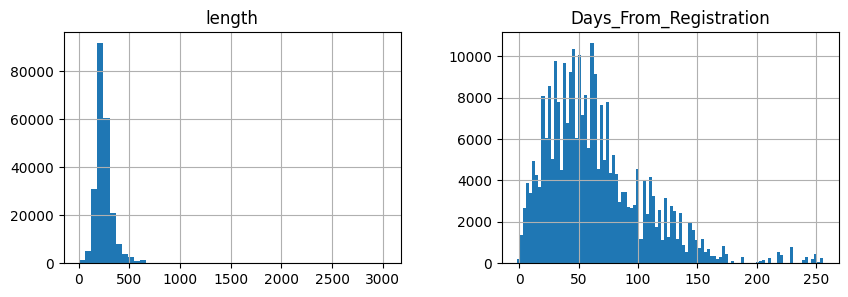

In [25]:
#Create two histograms for length and day from registration

plt.rcParams["figure.figsize"] = (10,3)
fig, axes =  plt.subplots(1, 2)

df_visualization.hist('length', bins= 50, ax=axes[0]);
df_visualization.hist('Days_From_Registration', bins=100, ax=axes[1]);

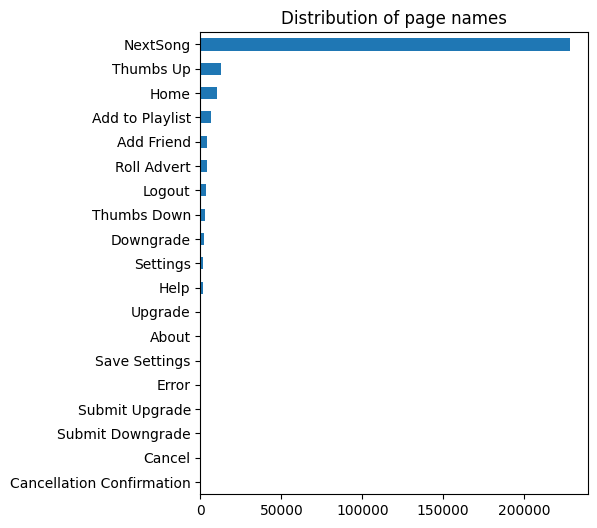

In [26]:
#Create barchart for values under page column and state
plt.rcParams["figure.figsize"] = (5,6)
df_visualization['page'].value_counts().sort_values().plot.barh(title="Distribution of page names");

plt.show(block=True)

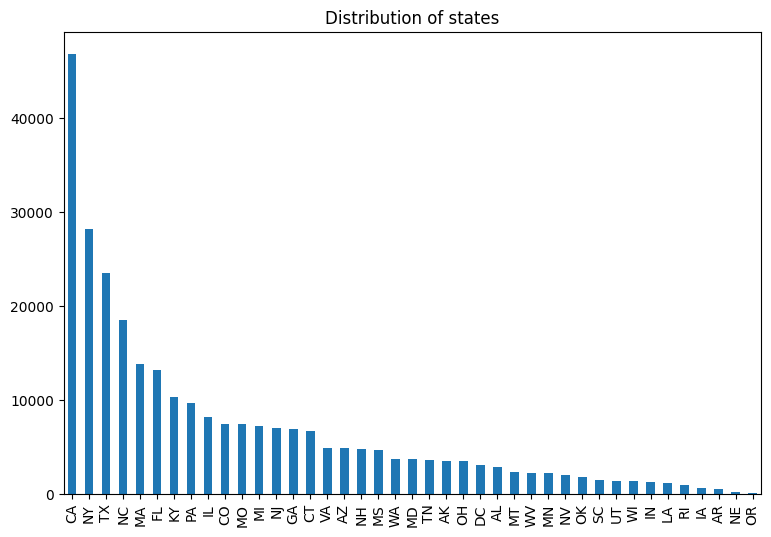

In [27]:
plt.rcParams["figure.figsize"] = (9,6)
df_visualization['State'].value_counts().plot.bar(title="Distribution of states");

plt.show(block=True)


1.	What is the overall trend of daily songs played for churned and un-churned customers?

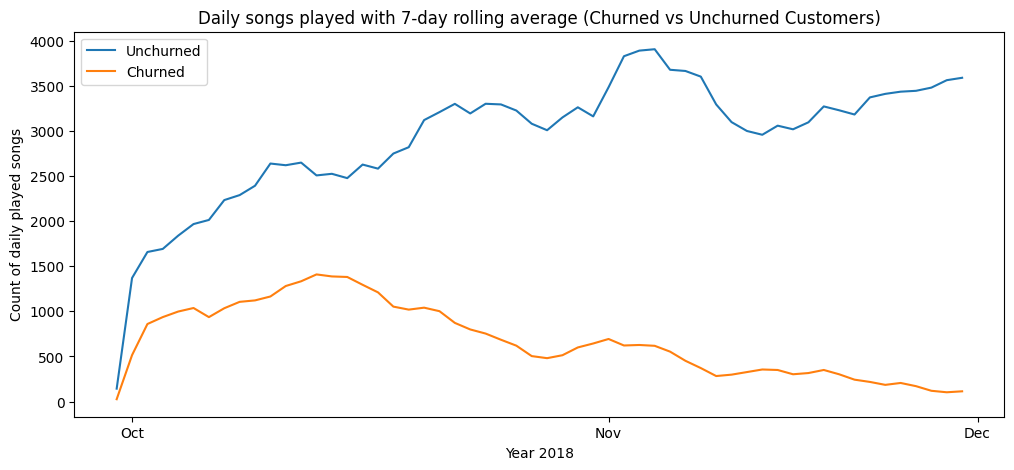

In [28]:
#Get seven day moving average for unchurned customers
df_roll_avg_Unchurned = spark.sql(''' Select A.datetime ,
                           Round (avg(Counts) OVER(Order by  A.datetime rows between 6 preceding and current row) , 2) as rolling_avg_Unchurned
                           From (SELECT  datetime , count(*) Counts 
                           FROM df_data A
                           join (SELECT distinct UserId  , sum( IsChurn)
                                 from  df_data
                                 group by UserId 
                                 having sum(IsChurn) = 0 ) B 
                                  On A.UserId = B.UserId
                           Where A.song is not null 
                           Group by A.datetime 
                           Order by A.datetime) A ''').toPandas()

#Get seven day moving average for churned customers
df_roll_avg_churned = spark.sql(''' Select A.datetime , 
                           Round (avg(Counts) OVER(Order by  A.datetime rows between 6 preceding and current row) , 2) 
                           as rolling_avg_Churned
                           From (SELECT  datetime , count(*) Counts 
                                FROM df_data A
                                join (SELECT distinct UserId  , sum( IsChurn)
                                     from  df_data
                                     group by UserId 
                                     having sum(IsChurn) > 0 ) B 
                                  On A.UserId = B.UserId
                           Where A.song is not null 
                           Group by A.datetime 
                           Order by A.datetime) A ''').toPandas()

#Merge two datasets on datetime column
df_all_roll_avg = pd.merge(df_roll_avg_Unchurned , df_roll_avg_churned , how = "inner" , on = "datetime")


# set figure size
plt.figure( figsize = ( 12, 5))
  
# plot a simple time series
sns.lineplot( x = 'datetime',
             y = 'rolling_avg_Unchurned',
             data = df_all_roll_avg,
             label = 'Unchurned')
  
# plot using rolling average
sns.lineplot( x = 'datetime',
             y = 'rolling_avg_Churned',
             data = df_all_roll_avg,
             label = 'Churned')
  
plt.xlabel('Year 2018')
  
# setting customized ticklabels for x axis
pos = [ '2018-10-01', '2018-11-01', '2018-12-01']

lab = [ 'Oct', 'Nov', 'Dec']
  
plt.title("Daily songs played with 7-day rolling average (Churned vs Unchurned Customers)")    
plt.xticks( pos, lab)
plt.ylabel('Count of daily played songs');

<b> Answer: </b> Values for un-churned customers are much higher and the overall trend is upward, as opposed to the downward trend observed for churned customers.

2.	Who are the most played artists in the top 10 locations?

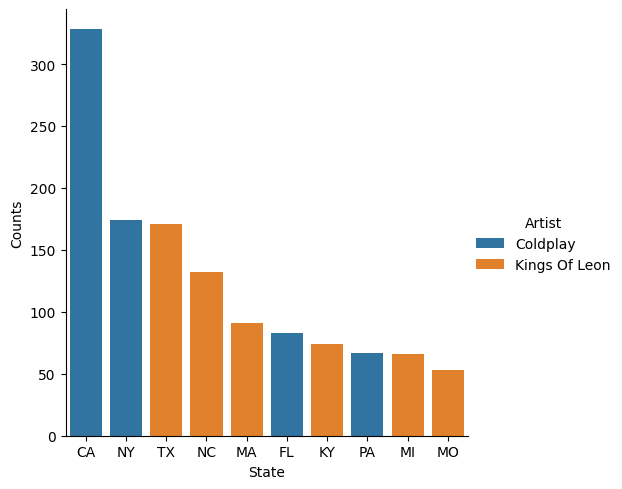

In [29]:
#Select artist and location from the view where we have removed null values
df_location_artist = spark.sql("SELECT  artist , State , count(*) as Counts \
                               FROM df_data  \
                               Where song is not null \
                               group by artist , State").toPandas()

#Get the maximum count for each state
df_location_artist['max'] = df_location_artist.groupby(['State']).Counts.transform(np.max)
#Keep only records values of which is equal to maximum value
df_location_artist = df_location_artist[df_location_artist['Counts'] == df_location_artist['max']] \
                                       .reset_index().drop(columns = ['index' , 'max'])

#In cases of a tie per each state keep the first record
df_location_artist = df_location_artist.drop_duplicates(subset='State') \
                                       .sort_values(by='Counts', ascending = False) \
                                       .reset_index().drop(columns = 'index')

#Get only top 10 records
df_location_artist = df_location_artist.head(10)
#Rename artist column
df_location_artist.rename(columns = {'artist':'Artist'} , inplace = True)
#Plot data
chart = sns.catplot(x ='State', y ='Counts' , data = df_location_artist ,  \
                     hue ='Artist' , dodge=False,  kind="bar" );

<b> Answer: </b> We can see that the 2 domineering artists are Coldplay and Kings of Leon. First one is the most played artist in California, New York and Florida, whereas the latter in the rest of the listed states.

3.	How does average number of songs differ between churned and un-churned customers across hours?

In [30]:
#Get counts by hour for unchurned
df_hr_counts_unchurned = spark.sql(''' SELECT  cast(A.hour as int) hour   , count(*) as Counts_Unchurned , "Unchurned"
                                       FROM df_data  A
                                       Join (SELECT distinct UserId  , sum( IsChurn)
                                                             from  df_data
                                                             group by UserId 
                                                             having sum(IsChurn) = 0 ) B 
                                       On A.UserId = B.UserId
                                       Where A.song is not null
                                       Group by A.hour
                                       order by A.hour''').toPandas()

#Get counts by hour for churned
df_hr_counts_churned = spark.sql(''' SELECT  cast(A.hour as int) hour   , count(*) as Counts_Churned , "Churned"
                                       FROM df_data  A
                                       Join (SELECT distinct UserId  , sum( IsChurn)
                                                             from  df_data
                                                             group by UserId 
                                                             having sum(IsChurn) > 0 ) B 
                                       On A.UserId = B.UserId
                                       Where A.song is not null
                                       Group by A.hour
                                       order by A.hour''').toPandas()

#Merge these two dataframes on 'hour'
df_hr_counts = pd.merge(df_hr_counts_unchurned , df_hr_counts_churned , on = "hour" )

In [31]:
df_totals = spark.sql(''' SELECT   count(*) Totals , 'Unchurned'
              FROM df_data  A
              Join (SELECT distinct UserId  , sum( IsChurn)
                    from  df_data
                    group by UserId 
                    having sum(IsChurn) = 0 ) B 
              On A.UserId = B.UserId
              Where A.song is not null
              
              Union 
              
              SELECT   count(*) Totals  , 'Churned'
              FROM df_data  A
              Join (SELECT distinct UserId  , sum( IsChurn)
                    from  df_data
                    group by UserId 
                    having sum(IsChurn) > 0 ) B 
              On A.UserId = B.UserId
              Where A.song is not null ''').toPandas()

df_totals.rename(columns = {'Unchurned':'IsChurned'}, inplace = True)
Total_Churned = df_totals['Totals'][df_totals['IsChurned'] == 'Churned'][1]
Total_Unchurned = df_totals['Totals'][df_totals['IsChurned'] == 'Unchurned'][0]


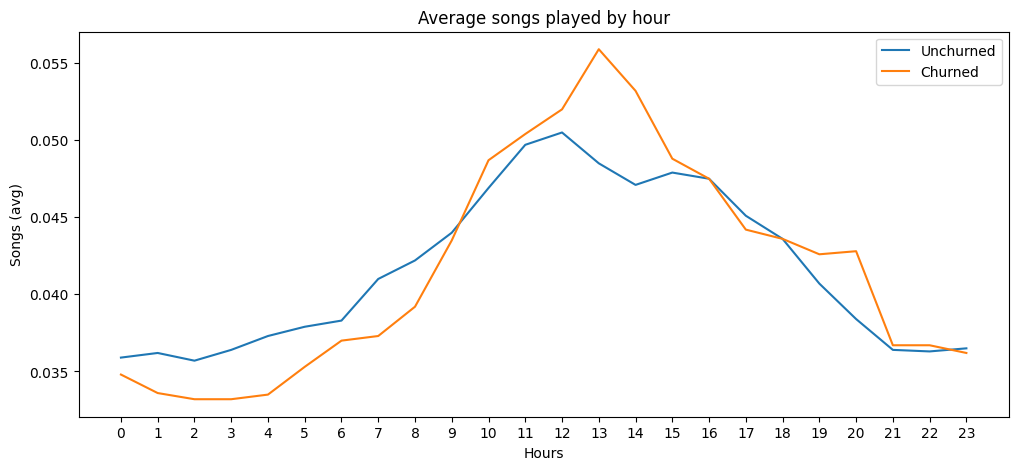

In [32]:
#Find averages for churned and unchurned
df_hr_counts['Avg Hourly Unchurned'] = (df_hr_counts['Counts_Unchurned'] / Total_Unchurned ).round(4)
df_hr_counts['Avg Hourly Churned']   = (df_hr_counts['Counts_Churned'] / Total_Churned).round(4)

#Sort by hour
df_hr_counts.sort_values(by = "hour" , inplace = True)


# set figure size
plt.figure( figsize = ( 12, 5))
  
# plot a simple time series
sns.lineplot( x = 'hour',
             y = 'Avg Hourly Unchurned',
             data = df_hr_counts,
             label = 'Unchurned')
  
# plot using rolling average
sns.lineplot( x = 'hour',
             y = 'Avg Hourly Churned',
             data = df_hr_counts,
             label = 'Churned')
  
plt.xlabel('Hours')
  
# setting customized ticklabels for x axis
pos = list(range(24))

lab = list(range(24))
  
plt.title("Average songs played by hour")    
plt.xticks( pos, lab)
plt.ylabel('Songs (avg)');

<b> Answer: </b> For the first group the average of songs played from 1 to 9 am is smaller. After 9 am, we see an increase for both groups which lasts until around 17 pm. During this interval, average songs played by churned customer is greater.

4.	How long after the registration did churned customers canceled their subscription?

In [33]:
df_customer_longevity = spark.sql(''' select A.Customer_Longevity , A.level , count(A.Counts) as Counts
                                      From ( Select Case when Days_From_Registration <= 30 Then "1-30 Days"
                                                          when Days_From_Registration > 30 and Days_From_Registration <= 60  Then "31-60 Days"
                                                          when  Days_From_Registration > 60 and Days_From_Registration <= 90  Then "61-90 Days" 
                                                          when  Days_From_Registration > 90  Then "> 90 Days"
                                                      end Customer_Longevity , Days_From_Registration , level , count(*) Counts
                                              FROM df_data 
                                              Where IsChurn = 1
                                              Group by Customer_Longevity , level ,Days_From_Registration 
                                              Order by Days_From_Registration ) A 
                                     Group by A.Customer_Longevity , A.level  ''').toPandas()

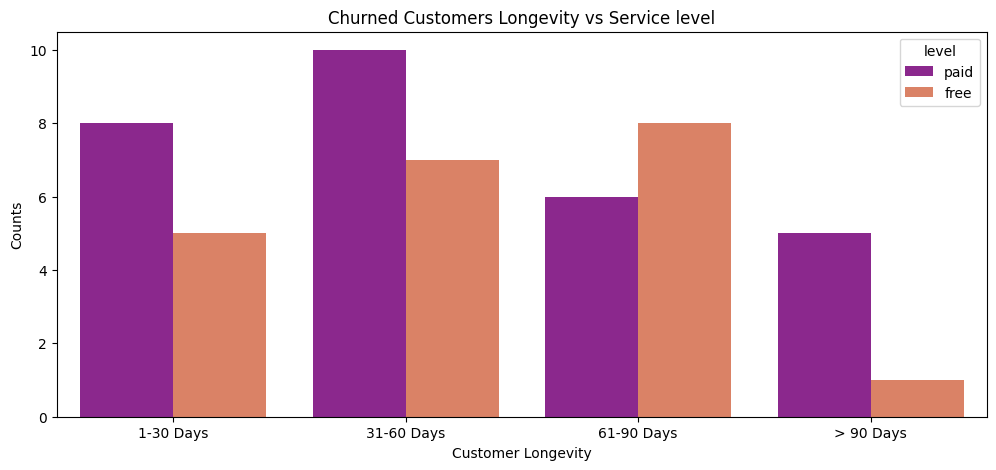

In [34]:
# set figure size
plt.figure( figsize = ( 12, 5))
ax = sns.barplot(data=df_customer_longevity, x="Customer_Longevity", y="Counts" , hue = 'level' ,
             order = ["1-30 Days" , "31-60 Days" , "61-90 Days" , "> 90 Days"] , palette ='plasma') 

ax.set(xlabel = "Customer Longevity" , title = "Churned Customers Longevity vs Service level");

<b> Answer: </b> From the graph we can see that number of churned customers who pay for the service is greater during the first two months. In majority of cases they start listening for free 2 months after registration.

5.	Is there any similarity in song preference between churned and un-churned customers?

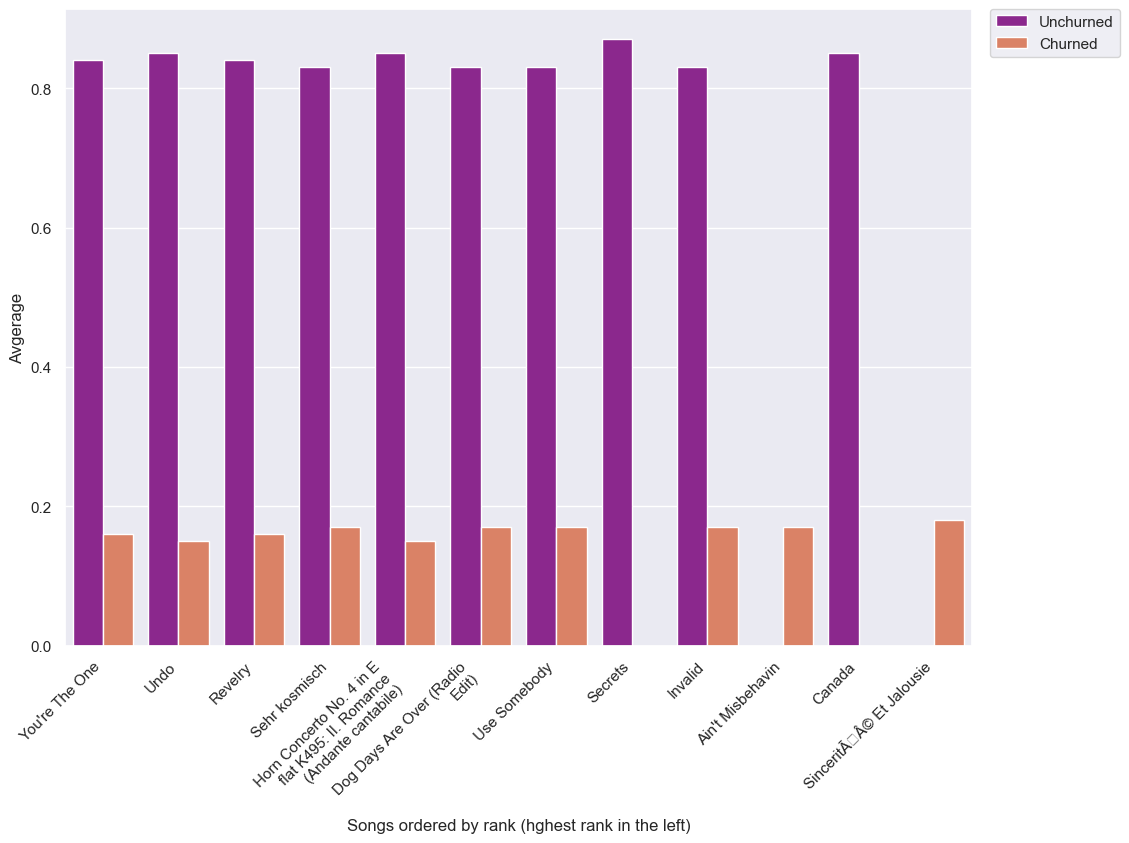

In [35]:
#Get songs and counts for each group
df_songs_churned = spark.sql('''SELECT A.song , count (*) as Counts 
                                       ,  count (*)  Over ( order by count (*) desc) as Order
                                       , 'Unchurned' 
                                FROM df_data A
                                 join (SELECT distinct UserId  , sum( IsChurn)
                                       from  df_data
                                       group by UserId 
                                       having sum(IsChurn) = 0 ) B 
                                 On A.UserId = B.UserId 
                                 Where A.song is not null and A.month <> 12
                                 Group by  A.song 

                                 Union 
                                 SELECT A.song , count (*) as Counts 
                                       ,  count (*)  Over ( order by count (*) desc) as Order
                                       ,  'Churned' 
                                FROM df_data A
                                 join (SELECT distinct UserId  , sum( IsChurn)
                                       from  df_data
                                       group by UserId 
                                       having sum(IsChurn) > 0 ) B 
                                 On A.UserId = B.UserId 
                                 Where A.song is not null and A.month <> 12
                                 Group by  A.song 
                                 order by Order ''').toPandas()

#Get total count for each song
df_all_songs = spark.sql('''SELECT A.song , count (*)  as Total_Count
                             FROM df_data A
                             Where A.song is not null and A.month <> 12
                             Group by  A.song ''').toPandas()

#Merge two dataframes on song
df_songs_churned = pd.merge(df_songs_churned , df_all_songs , on = 'song' , how = 'inner')
#Get top 10 songs for each group
df_songs_churned = df_songs_churned[df_songs_churned['Order'] <= 10].sort_values(by = "Order")


#Get average for each song for each group
df_songs_churned['Avgerage'] = (df_songs_churned['Counts'] / df_songs_churned['Total_Count'] ).round(2)
df_songs_churned.rename(columns = {'Unchurned' : 'IsChurn' , 'song':'Song Name'} , inplace = True)
#Reformat song name to fit in the x-axis
df_songs_churned['Song Name'] = df_songs_churned['Song Name'].apply(lambda row: '\n'.join(wrap(row, 25)))
#Plot the data
%matplotlib inline
sns.set()
sns.set_theme() 
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
chart = sns.barplot(x ='Song Name', y ='Avgerage', hue = 'IsChurn' , data = df_songs_churned,palette ='plasma')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(xlabel = "Songs ordered by rank (hghest rank in the left)")
chart.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);


<b> Answer </b> Song preferences are very similar.

6. Is there any correlation between Apple device users and churned/un-churned customers?

In [36]:
#Get a counts for churned vs unchurned for Apple vs nonApple 

df_IsApple = spark.sql('''Select  A.IsApple , count(*) Count , 'Unchurned'
                      FROM df_data A
                      join (SELECT distinct UserId  , sum( IsChurn)
                            from  df_data
                            group by UserId 
                            having sum(IsChurn) = 0) E
                        On A.UserId = E.UserId 
            Group by A.IsApple
            
            Union 
            
            Select  A.IsApple , count(*) Count , 'Churned'
                      FROM df_data A
                      join (SELECT distinct UserId  , sum( IsChurn)
                            from  df_data
                            group by UserId 
                            having sum(IsChurn) > 0) E
                        On A.UserId = E.UserId 
            Group by A.IsApple 
            Order by IsApple''').toPandas()

#Get total counts for Apple vs Non Apple

df_IsApple_totals = spark.sql(''' select IsApple , count(*) Total_Counts 
                                  FROM df_data
                                  Group by IsApple  ''').toPandas()

# Merge above datasets
df_IsApple = pd.merge(df_IsApple , df_IsApple_totals , how = 'inner' , on = 'IsApple')
# Get averages for each group
df_IsApple['Avgerage'] = df_IsApple['Count']  / df_IsApple['Total_Counts']
#Rename IsApple column
df_IsApple.loc[df_IsApple['IsApple'] == 0 , 'IsApple'] = 'Non-Apple Device'
df_IsApple.loc[df_IsApple['IsApple'] == 1 , 'IsApple'] = 'Apple Device'
#Round average
df_IsApple['Avgerage (%)'] = (df_IsApple['Avgerage'] * 100).round(3)
#Rename unchurned column
df_IsApple.rename(columns = {'Unchurned':'IsChurned' , 'IsApple':'Device'} , inplace = True)

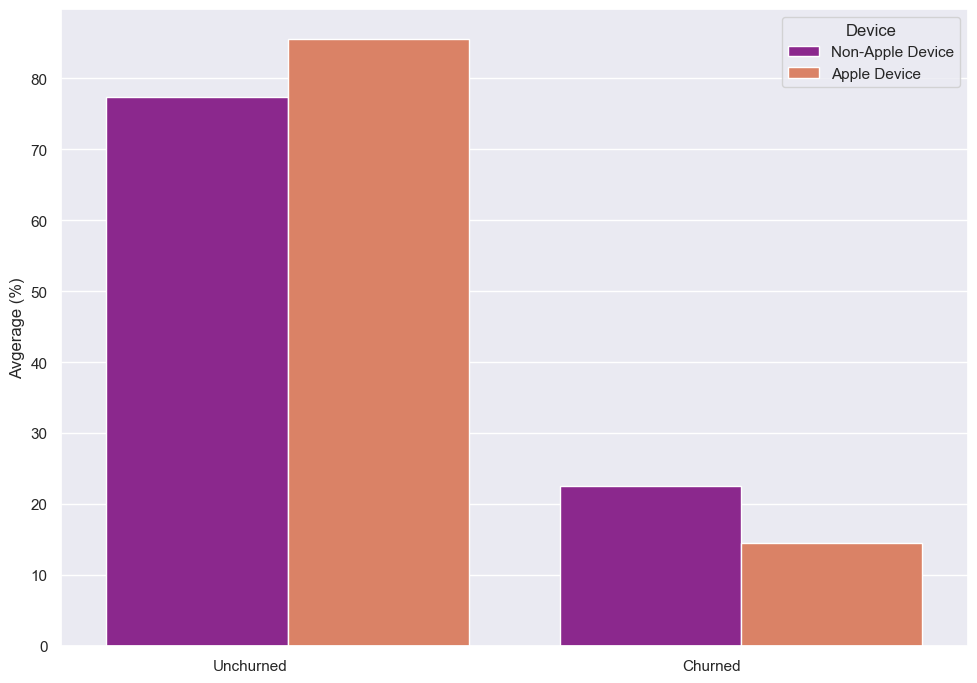

In [37]:
#Plot the data
sns.set(rc={'figure.figsize':(11.7,8.27)})
chart = sns.barplot(x ='IsChurned', y ='Avgerage (%)', hue = 'Device' , data = df_IsApple, palette ='plasma');
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right')
chart.set(xlabel=None)
plt.show()

<b> Aswer </b> On average, non-Apple device users make up most of the churned customers. Same idea holds true for un-churned side where Apple device users hold a higher percentage.

#### **Section 3** : Feature Engineering

- Create new features from raw dataset 

In [38]:
#Create a udf function which will be applied on the State column
#Get top state
top_state = ' '.join(list(df_location_artist['State'])[:1])

#If name is same as the top state than top state else 'other state'
def  determine_state(col_value ):
    if col_value == top_state:
        return top_state
    else:
        return "other_state"

udf_determine_state = udf(determine_state, StringType())
df_data = df_data.withColumn('State_', udf_determine_state(col('State')  ) )
df_data.createOrReplaceTempView("df_data") 

In [39]:
#Get aggreagations on length, IsChurn, song, artist, IsApple and days from registration columns
df_numerical = df_data.groupBy("userId") \
                         .agg(avg("length").alias("avg_session_length"), \
                              sum("length").alias("sum_session_length"), \
                              max("length").alias("max_session_length") , \
                              stddev("length").alias("stdev_session_length"), \
                              min("length").alias("min_session_length") , \
                              max("IsChurn").alias("churn") , \
                              countDistinct("song").alias("distinct_song") ,\
                              countDistinct("artist").alias("distinct_artist") ,\
                              max("IsApple").alias("apple_device_user") ,\
                              max("Days_From_Registration").alias("max_days_from_registration") ,\
                              min("Days_From_Registration").alias("min_days_from_registration")  ,\
                              avg("Days_From_Registration").alias("avg_days_from_registration"))

#Get dummies for page column
df_data = df_data.groupBy(df_data.columns).pivot('page').agg(F.count('*')).fillna(0)
#Get dummies for level column
df_data = df_data.groupBy(df_data.columns).pivot('level').agg(F.count('*')).fillna(0)
#Get dummies for state column
df_data = df_data.groupBy(df_data.columns).pivot('State_').agg(F.count('*')).fillna(0)

#Delete rows pertaining to December month since they appear to be outliers.
df_data = df_data.filter(~(df_data.month == 12))

#Get aggreagations on categorical features
df_categorical = df_data.groupBy("userId") \
                         .agg( sum("NextSong").alias("sum_next_song") ,\
                               sum("Thumbs Up").alias("sum_thumbs_up") ,\
                               sum("Home").alias("sum_home") ,\
                               sum("Add to Playlist").alias("sum_add_to_playlist") ,\
                               sum("Add Friend").alias("sum_add_friend") ,\
                               sum("Roll Advert").alias("sum_roll_advert") ,\
                               sum("Logout").alias("sum_logout") ,\
                               sum("Thumbs Down").alias("sum_thumbs_down") ,\
                               sum("Downgrade").alias("sum_downgrade") ,\
                               sum("CA").alias("sum_ca") )

#Perform join between two datasets
df_joined = df_categorical.join(df_numerical, on = 'userId')  

#Get number of rows and columns for the dataset that will be used for ML
print((df_joined.count(), len(df_joined.columns)))

(225, 23)


In [40]:
#Visualize the newly created dataframe
df_joined.toPandas().head(3)  

,userId,sum_next_song,sum_thumbs_up,sum_home,sum_add_to_playlist,sum_add_friend,sum_roll_advert,sum_logout,sum_thumbs_down,sum_downgrade,sum_ca,avg_session_length,sum_session_length,max_session_length,stdev_session_length,min_session_length,churn,distinct_song,distinct_artist,apple_device_user,max_days_from_registration,min_days_from_registration,avg_days_from_registration
0,200002,387,21,20,8,4,7,5,6,5,0,242.916992,94008.87594,592.06485,75.447490,26.56608,0,378,339,1,70,25,49.698312
1,100010,275,17,11,7,4,52,5,5,0,0,243.421445,66940.89735,538.85342,79.515654,52.27057,0,269,252,1,56,12,33.611549
2,125,8,0,0,0,0,1,0,0,0,0,261.139138,2089.11310,391.26159,78.111065,178.41587,1,8,8,1,72,72,72.000000


- Prepare the dataset for ML model

In [41]:
#Create a list of predictor columns
predictors = []

for i in df_joined.columns:
    if i not in ('userId','churn'):
        predictors.append(i)

#Prepare data for ML algorithm by combining columns to a single column
vec_assembler = VectorAssembler(inputCols=predictors, outputCol='features')
#Apply the assembler to the dataset
transf_dataset = vec_assembler.transform(df_joined)
#Select only necessary columns
transf_dataset = transf_dataset.select(col('features'), col('churn').alias('label'))
#Visualize how the transformation looks like
transf_dataset.toPandas().head(1)

,features,label
0,"[387.0, 21.0, 20.0, 8.0, 4.0, 7.0, 5.0, 6.0, 5.0, 0.0, 242.91699209302305, 94008.87593999993, 592.06485, 75.447490312729, 26.56608, 378.0, 339.0, 1.0, 70.0, 25.0, 49.69831223628692]",0


In [42]:
#Create an object from standard scaler
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
#Fit the scaler
fitted_scaler = scaler.fit(transf_dataset)
#Scale the dataset
dataset_scaled = fitted_scaler.transform(transf_dataset)

transf_dataset = dataset_scaled.select(col('scaled_features').alias('features'), col('label'))
#Visualize how the scaled dataset looks like
transf_dataset.toPandas().head(1)

,features,label
0,"[-0.5672662987623749, -0.5312053249990139, -0.524543830614808, -0.6420107780186697, -0.7292340618073144, -0.48630623004932, -0.6084690494437063, -0.4064663105600868, -0.35224034059109965, -0.2493551449895035, -1.0151183296737223, -0.5757135622507943, -0.9089012494704861, -1.0703270859727976, -0.38974864976474966, -0.5798731581380153, -0.5917322151164089, 0.5264710031632484, -0.25962133731226567, -0.40540695265852816, -0.2984405487831303]",0


#### **Section 4** : Modeling

7.	Which is the best classification model that can predict customer churn?

In [45]:
#Split the data into training and test sets
train_set, test_set  = transf_dataset.randomSplit([0.8, 0.2], seed=42)
#Check the total count in training and testing sets
print(f"Records in training set: {train_set.count()} ; Records in testing set: {test_set.count()}" )

Records in training set: 190 ; Records in testing set: 35


### Random Forest

In [46]:
#Create an instance of Random Forest ML
rf = RandomForestClassifier(maxBins=5, maxDepth=5,numTrees=5 , seed=41) 
rf_model = rf.fit(train_set)
rf_pred = rf_model.transform(test_set)

In [47]:
#Create an instance of evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
#Get accuracy and f1 score from RF best model
accuracy = evaluator.evaluate(rf_pred, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print('Test set metrics:')
print(f'Accuracy: {accuracy}')
print(f'F-1 Score: {f1_score}')

Test set metrics:
Accuracy: 0.8285714285714286
F-1 Score: 0.7912442396313363


### Gradient Boosted Tree Classifier

In [48]:
#Create an instance of Gradient Boosted Tree Classifier
gbt_final = GBTClassifier(maxDepth=25, maxIter=60 , seed=41) 
gbt_final_model = gbt_final.fit(train_set)
gbt_predictions = gbt_final_model.transform(test_set)

In [49]:
#Create an instance of evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
#Get accuracy and f1 score from RF best model
accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})
print('Test set metrics:')
print(f'Accuracy: {accuracy}')
print(f'F-1 Score: {f1_score}')

Test set metrics:
Accuracy: 0.7428571428571429
F-1 Score: 0.7615584415584415


### Decision Tree Classifier

In [50]:
#Create an instance of Decision Tree Classifier
dt_final = DecisionTreeClassifier(impurity="entropy", maxDepth = 5 , maxBins = 32) 
dt_final_model = dt_final.fit(train_set)
dt_predictions = dt_final_model.transform(test_set)

In [51]:
#Create an instance of evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
#Get accuracy and f1 score from RF best model
accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})
print('Test set metrics:')
print(f'Accuracy: {accuracy}')
print(f'F-1 Score: {f1_score}')

Test set metrics:
Accuracy: 0.7428571428571429
F-1 Score: 0.7504916136495083


### Support Vector Machine

In [52]:
#Create an instance of K-nearest neighbor
svc_final = LinearSVC(maxIter=10, regParam=0.1)
svc_final_model = svc_final.fit(train_set)
svc_predictions = svc_final_model.transform(test_set)

In [53]:
#Create an instance of evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
#Get accuracy and f1 score from RF best model
accuracy = evaluator.evaluate(svc_predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(svc_predictions, {evaluator.metricName: "f1"})
print('Test set metrics:')
print(f'Accuracy: {accuracy}')
print(f'F-1 Score: {f1_score}')

Test set metrics:
Accuracy: 0.8285714285714286
F-1 Score: 0.7508928571428571


<b> Answer </b> The best model is Random Forest

### Hypertune the model

In [54]:
#Create an object for random forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

#Build a grid with parameters for cross-validation
rf_Grid = ParamGridBuilder() \
                  .addGrid(rf.maxDepth, [10 , 15]) \
                  .addGrid(rf.maxBins,  [23 , 25]) \
                  .addGrid(rf.numTrees, [10 , 15]) \
                  .build()

#Create a 5-fold CrossValidator
rf_cross_valid = CrossValidator(estimator=rf,
                          estimatorParamMaps= rf_Grid,
                          evaluator= MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=5)
#Run cross validations
rf_cv = rf_cross_valid.fit(train_set)
rf_cv.avgMetrics

[0.7706394163727662,
 0.7844960330674617,
 0.7550342597711793,
 0.7929443002219957,
 0.7582470634410161,
 0.7844960330674617,
 0.7550342597711793,
 0.7929443002219957]

- Create a list with the set of hyperparameters from cross-validation process

In [55]:
all_params = []

#Loop through all cross-validation parameters and seve them into a list of dictionaries
for m in rf_cv.getEstimatorParamMaps():
    params_a = {}
    for p, v in m.items() :
        params_a[p.name] =  v 
    all_params.append(params_a)

In [56]:
#Loop through F-values and the list of hyperparameters created by cross-validation and store it in a dictionary
df_params = {}

for  f_val , cv_i  in  zip( rf_cv.avgMetrics , all_params):
       df_params[f_val]  = cv_i

#Create a dataframe from the above dictionary
df_params = pd.DataFrame.from_dict(df_params).T
#Sort the dataframe based on the F-value to get the best model
df_params = df_params.reset_index().rename(columns = {'index':'F1-Score'}).sort_values(by="F1-Score" , ascending =  False)
df_params

,F1-Score,maxDepth,maxBins,numTrees
3,0.792944,15,25,15
1,0.784496,15,23,15
0,0.770639,10,23,10
4,0.758247,15,23,10
2,0.755034,15,25,10


In [57]:
#Use above parameters to create an instance of random forest
rf_final = RandomForestClassifier(maxBins=25, maxDepth=15,numTrees=10 , seed=41)  
rf_final_model = rf_final.fit(train_set)
rf_predictions = rf_final_model.transform(test_set)

In [58]:
#Create an instance of evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
#Get accuracy and f1 score from RF best model
accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})
print('Test set metrics:')
print(f'Accuracy: {accuracy}')
print(f'F-1 Score: {f1_score}')

Test set metrics:
Accuracy: 0.8285714285714286
F-1 Score: 0.8142857142857144


8.	What features important in the best classification model?

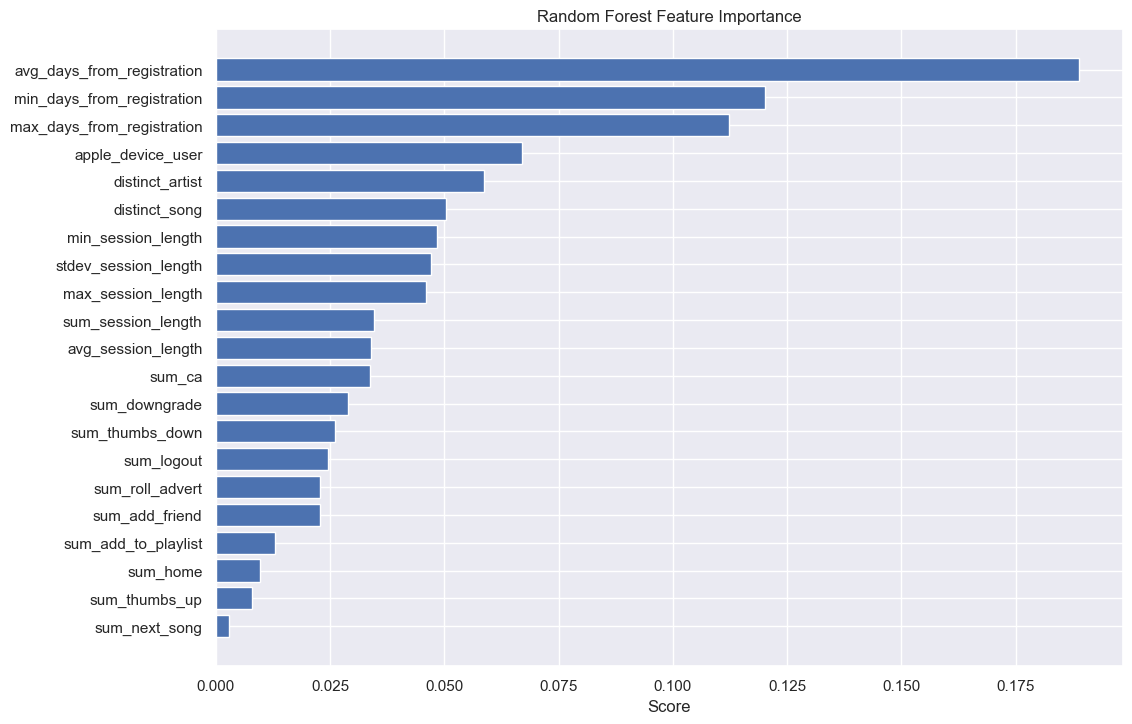

In [59]:
#Get feature imprance from the model and plot it
feature_importance = rf_final_model.featureImportances.values
feature_importance = np.sort(feature_importance)
y_pos = np.arange(len(predictors))
plt.barh(y_pos, feature_importance, align='center')
plt.yticks(y_pos, predictors)
plt.xlabel('Score')
plt.title('Random Forest Feature Importance');

<b> Answer </b> As it can be observed, days from registration and apple device user are features with the highest influence in the model.